In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import measure
from scipy.ndimage import label
import os

In [2]:
# Step 1: Preprocess the input image
def preprocess_image(image_path, img_size=(256, 256)):
    """
    Preprocess the input image by loading it in grayscale, resizing, and normalizing pixel values.

    Args:
        image_path (str): Path to the input image file.
        img_size (tuple): Desired size for the output image (width, height). Default is (256, 256).

    Returns:
        np.ndarray: Preprocessed image with normalized pixel values.
    """
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to the specified size
    image_resized = cv2.resize(image, img_size)
    
    # Normalize pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0
    
    return image_normalized

In [3]:
# Step 2: Region-growing algorithm
def region_growing(image, seeds, threshold=0.1):
    """
    Perform region growing segmentation on the input image starting from the given seed points.

    Args:
        image (np.ndarray): Input grayscale image.
        seeds (list of tuple): List of (x, y) coordinates of the seed points.
        threshold (float): Intensity threshold for region growing. Default is 0.1.

    Returns:
        np.ndarray: Segmentation mask with the same dimensions as the input image.
    """
    # Get the image dimensions
    h, w = image.shape
    
    # Initialize the output mask for the segmented region
    segmented = np.zeros_like(image, dtype=np.uint8)
    
    # Define the connectivity (4-connectivity: up, down, left, right)
    connectivity = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # List of seeds to process
    seed_list = seeds[:]
    
    # Grow region from each seed
    while seed_list:
        # Pop the first seed from the list
        x, y = seed_list.pop(0)
        
        # Check if the pixel is already segmented
        if segmented[x, y] == 1:
            continue
        
        # Mark the pixel as part of the segmented region
        segmented[x, y] = 1
        
        # Get the intensity value of the current pixel
        pixel_value = image[x, y]
        
        # Expand to neighbors
        for dx, dy in connectivity:
            xn, yn = x + dx, y + dy
            # Check if the neighboring pixel is within the image bounds and not yet segmented
            if 0 <= xn < h and 0 <= yn < w and segmented[xn, yn] == 0:
                # Check if the neighboring pixel is within the intensity threshold
                if abs(image[xn, yn] - pixel_value) < threshold:
                    seed_list.append((xn, yn))
    
    return segmented

In [4]:
# Step 3: Heuristic for selecting seeds
def select_seeds(image):
    """
    Manually selects two seeds for the kidneys. In a real-world scenario,
    this would either be provided by a user or determined heuristically.
    """
    h, w = image.shape
    
    # Heuristic to select left and right kidney seeds: choose middle-left and middle-right
    # left_seed = (h // 2, w // 3)  # Approximate location of left kidney
    # right_seed = (h // 2, 2 * w // 3)  # Approximate location of right kidney
    left_seed = (150, 60)
    right_seed = (150, 185)
    
    return [left_seed, right_seed]

In [5]:
# Step 4: Post-process to separate left and right kidneys
def separate_kidneys(segmentation_mask):
    """
    Separate the left and right kidneys from the segmentation mask.

    Args:
        segmentation_mask (np.ndarray): Binary segmentation mask where kidneys are labeled.

    Returns:
        tuple: Two binary masks, one for the left kidney and one for the right kidney.
               If the expected number of kidneys is not found, returns (None, None).
    """
    # Label connected regions in the segmentation mask
    labeled_mask, num_labels = label(segmentation_mask)
    
    # Check if the number of labeled regions is not equal to 2
    if num_labels != 2:
        print(f"Warning: Expected 2 kidneys, found {num_labels}")
    
    # Get properties of labeled regions
    regions = measure.regionprops(labeled_mask)
    
    if len(regions) == 2:
        # Sort regions based on centroids (left kidney should be left-most)
        regions = sorted(regions, key=lambda x: x.centroid[1])
        left_kidney = labeled_mask == regions[0].label
        right_kidney = labeled_mask == regions[1].label
        return left_kidney, right_kidney
    
    elif len(regions) == 1:
        # If only one region is found, assume it is the left kidney
        left_kidney = labeled_mask == regions[0].label
        right_kidney = np.zeros_like(segmentation_mask)
        return left_kidney, right_kidney

    else:
        # If no regions or more than two regions are found, return None
        return None, None

In [6]:
# Step 5: Visualize the segmentation results
def visualize_results(image, left_kidney, right_kidney, seed_points):
    """
    Visualize the segmentation results by overlaying the left and right kidney masks on the original image.

    Args:
        image (np.ndarray): Original grayscale image.
        left_kidney (np.ndarray): Binary mask for the left kidney.
        right_kidney (np.ndarray): Binary mask for the right kidney.
        seed_points (list of tuple): List of (x, y) coordinates of the seed points.
    """
    # Create a color version of the original grayscale image for visualization
    left_kidney_color_image = np.stack((image,)*3, axis=-1)
    right_kidney_color_image = np.stack((image,)*3, axis=-1)
    
    # Overlay the left kidney mask in red
    left_kidney_color_image[left_kidney > 0] = [255, 0, 0]
    
    # Overlay the right kidney mask in blue
    right_kidney_color_image[right_kidney > 0] = [0, 0, 255]
    
    # Create a figure with a specified size
    plt.figure(figsize=(15, 5))

    # Plot the original grayscale image with seed points
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.scatter([p[1] for p in seed_points], [p[0] for p in seed_points], c='w', marker='x', s=100)
    plt.title('Original Image')
    
    # Plot the left kidney overlay with the seed point
    plt.subplot(1, 3, 2)
    plt.imshow(left_kidney_color_image)
    plt.scatter(seed_points[0][1], seed_points[0][0], c='w', marker='x', s=100)
    plt.title('Left Kidney Overlay')

    # Plot the right kidney overlay with the seed point
    plt.subplot(1, 3, 3)
    plt.imshow(right_kidney_color_image)
    plt.scatter(seed_points[1][1], seed_points[1][0], c='w', marker='x', s=100)
    plt.title('Right Kidney Overlay')

In [7]:
# Step 6: Save generated masks
def save_kidney_masks(left_kidney, right_kidney, mask_filename):
    """
    Save the left and right kidney masks as a combined image.

    Args:
        left_kidney (np.ndarray): Binary mask for the left kidney.
        right_kidney (np.ndarray): Binary mask for the right kidney.
        mask_filename (str): Filename to save the combined mask image.
    """
    # Convert boolean masks to uint8 images (0 or 255 for left kidney, 0 or 127 for right kidney)
    left_kidney_image = (left_kidney * 255).astype(np.uint8)
    right_kidney_image = (right_kidney * 127).astype(np.uint8)
    
    # Combine the left and right kidney masks into a single image
    combined_image = left_kidney_image + right_kidney_image
    
    # Save the combined image in .jpg format
    cv2.imwrite(mask_filename, combined_image)

In [8]:
# Main function to run the region-growing pipeline
def main(image_path, output_path):
    # Step 1: Preprocess the image
    image = preprocess_image(image_path)
    
    # Step 2: Select seeds (for left and right kidneys)
    seeds = select_seeds(image)
    
    # Step 3: Apply region growing
    region_mask = region_growing(image, seeds, threshold=0.02)
    
    # Step 4: Separate left and right kidneys
    left_kidney, right_kidney = separate_kidneys(region_mask)
    
    # Step 5: Visualize the results
    if left_kidney is not None and right_kidney is not None:
        visualize_results(image, left_kidney, right_kidney, seeds)
    else:
        print("Failed to detect two separate kidneys.")

    # Step 6: Save the generated masks
    save_kidney_masks(left_kidney, right_kidney, output_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

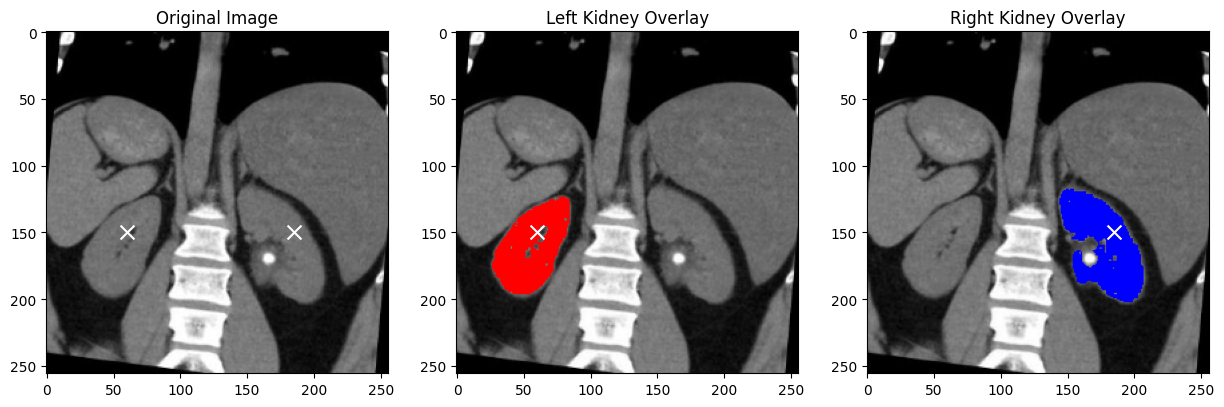

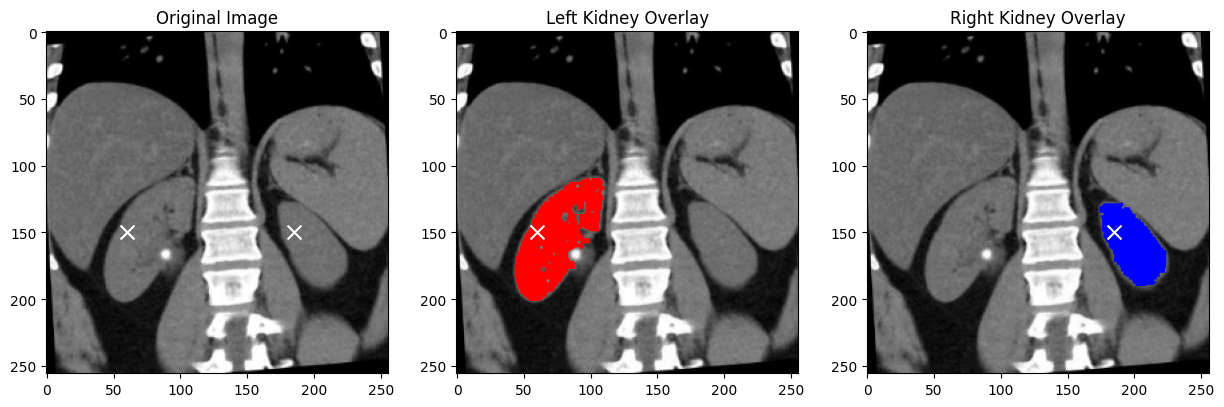

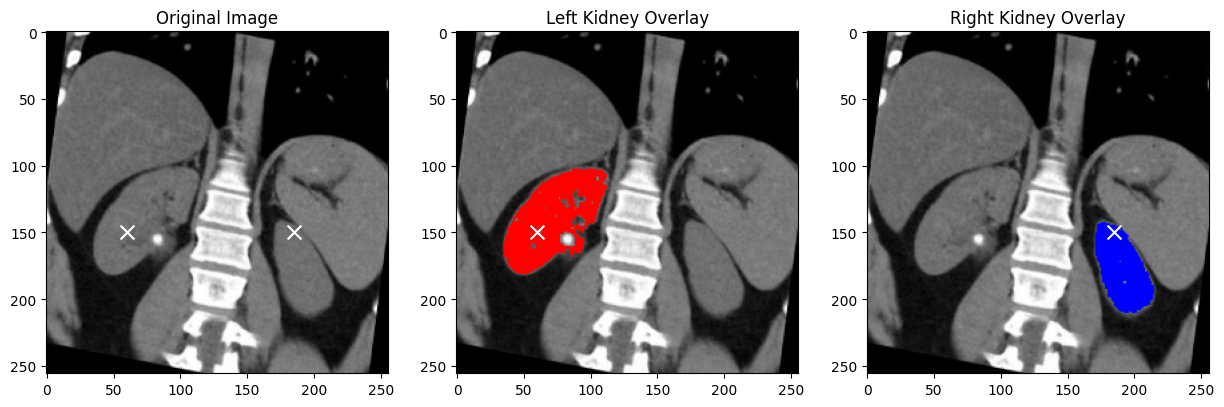

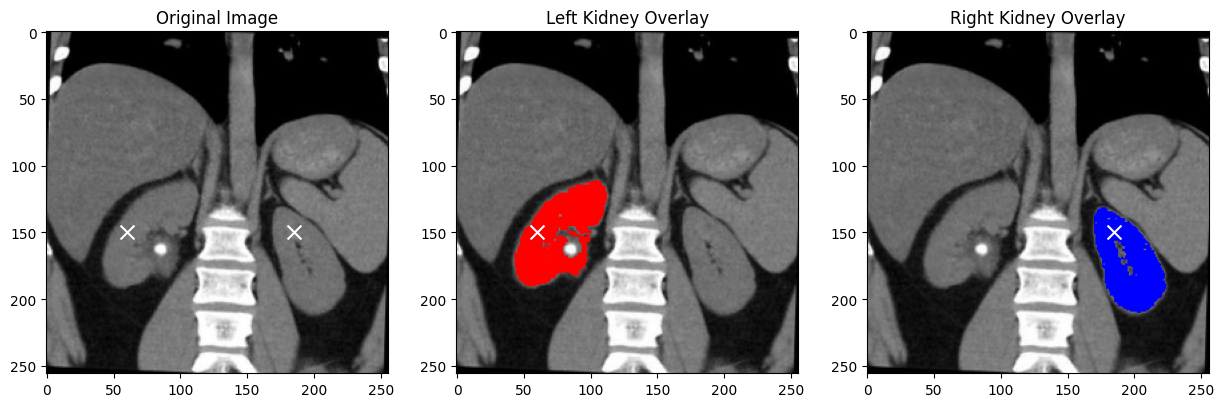

In [9]:
# Example usage
if __name__ == "__main__":
    """
    Processes all images in the specified directory and generates corresponding masks.
    """
    # Define the input directory containing the images
    image_dir_path = "../data/labeled/images"
    
    # Define the output directory to save the generated masks
    output_dir_path = "../data/labeled/masks"
    
    for image_file in os.listdir(image_dir_path)[:]:
        if image_file.endswith(".jpg"):
            image_file_path = os.path.join(image_dir_path, image_file)
            output_file = image_file.replace(".jpg", "_mask.png")
            output_file_path = os.path.join(output_dir_path, output_file)
            
            # Call the main function to process the image and generate the mask
            main(image_file_path, output_file_path)